In [1]:
import $file.scripts.importer

importer.loadProjectDependencies

import $file.$               



In [2]:
import smile.read
import smile.plot._
import smile.util._
import smile.math._, Math._

import smile.data._
import smile.interpolation._
import smile.validation._
import smile.manifold._
import smile.mds._
import smile.projection._

import scala.collection.JavaConverters._
import scala.collection.JavaConversions._
import edu.stanford.math.plex4._
import edu.stanford.math.plex4.api._
import edu.stanford.math.plex4.visualization._
import edu.stanford.math.plex4.homology.barcodes._
import edu.stanford.math.plex4.streams.impl.LazyWitnessStream

import breeze.numerics._
import breeze.linalg._
import breeze.math._
import breeze.stats.{mean, stddev}
import breeze.util.JavaArrayOps

import tda.persistence.Analysis._
import tda.persistence.Math._

import smile.read

import smile.plot._

import smile.util._

import smile.math._, Math._


import smile.data._

import smile.interpolation._

import smile.validation._

import smile.manifold._

import smile.mds._

import smile.projection._


import scala.collection.JavaConverters._

import scala.collection.JavaConversions._

import edu.stanford.math.plex4._

import edu.stanford.math.plex4.api._

import edu.stanford.math.plex4.visualization._

import edu.stanford.math.plex4.homology.barcodes._

import edu.stanford.math.plex4.streams.impl.LazyWitnessStream


import breeze.numerics._

import breeze.linalg._

import breeze.math._

import breeze.stats.{mean, stddev}

import breeze.util.JavaArrayOps


import tda.persistence.Analysis._

import tda.persistence.Math._

In [3]:
def drawBarcodes(images: Seq[java.awt.image.BufferedImage]) = {
  images foreach publish.png 
}

val maxDimension = 3
lazy val persistence = Plex4.getModularSimplicialAlgorithm(maxDimension, 2)

def lazyStreamIntervalsWithImages(data: Array[Array[Double]], scale: Double) = {
  val noLandmarkPoints = 50
  val numDivisions = 100 

  lazy val landmarkSelector = Plex4
    .createMaxMinSelector(data, noLandmarkPoints)

  lazy val landmarkIndices = landmarkSelector.getLandmarkPoints()

  val D = landmarkSelector.getMaxDistanceFromPointsToLandmarks 

  lazy val filtrationValue = scale * D  

  lazy val patchesLandmarksStream = new LazyWitnessStream(
    landmarkSelector.getUnderlyingMetricSpace,
    landmarkSelector,
    maxDimension,
    filtrationValue,
    1,
    numDivisions)

  patchesLandmarksStream.finalizeStream()
  
  (
    patchesLandmarksStream.getSize,
    filtrationValue,
    intervalsWithImages(
      patchesLandmarksStream,
      maxDimension,
      filtrationValue,
      persistence)  
  )
}

def time[R](block: => R): R = {
    val t0 = System.currentTimeMillis()
    val result = block    // call-by-name
    val t1 = System.currentTimeMillis()
    println("Elapsed time: " + ((t1 - t0) / 1000.0) + "s")
    result
}

defined function drawBarcodes
maxDimension: Int = 3
persistence: homology.interfaces.AbstractPersistenceAlgorithm[homology.chain_basis.Simplex] = <lazy>
defined function lazyStreamIntervalsWithImages
defined function time

# Natural image patches
idea for analysis and dataset comes from [On the Local Behavior of Spaces of Natural Images](http://math.uchicago.edu/~shmuel/AAT-readings/Data%20Analysis%20/mumford-carlsson%20et%20al.pdf)

(points15 is X(15, 30) from the paper)

In [4]:
lazy val points15 = read.csv("../data/pointsDct15.csv").unzip

points15: Array[Array[Double]] = <lazy>

In [5]:
lazy val (patchesStreamSize, filtrationValue, (_, patchesLandmarkImages))= lazyStreamIntervalsWithImages(points15, 1)

patchesStreamSize: Int = <lazy>
filtrationValue: Double = <lazy>
patchesLandmarkImages: List[java.awt.image.BufferedImage] = <lazy>

Image patches stream for
maxFiltrationValue = 0.6575749248107894
has 135082 simplices


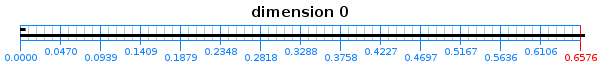

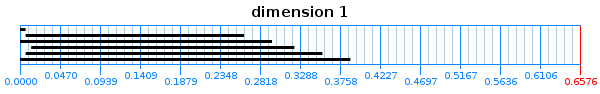

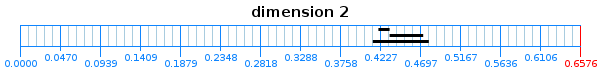

In [6]:
println(Seq(
  "Image patches stream for",
  s"maxFiltrationValue = ${filtrationValue}",
  s"has ${patchesStreamSize} simplices").mkString("\n"))

drawBarcodes(patchesLandmarkImages)

# Sampling

We downsample the dataset to make running manifold learning algorithms feasible (running Smile on the whole dataset takes up too much memory).

In [7]:
val subsampledPoints15 = time { subsampleByMaxmin(1250, points15) }

Elapsed time: 401.165s


subsampledPoints15: Array[Array[Double]] = Array(
  Array(
    0.5876577815072993,
    -0.6987115426157965,
    0.046692374268362785,
    -0.3543812583918219,
    0.18623649222463423,
    -0.05641813327217153,
    -0.0031351054652918736,
    -0.028588680320568917
  ),
  Array(
...

In [8]:
lazy val (sampledPatchesStreamSize, sampledFiltrationValue, (_, sampledPatchesLandmarkImages))= lazyStreamIntervalsWithImages(subsampledPoints15, 0.7)

sampledPatchesStreamSize: Int = <lazy>
sampledFiltrationValue: Double = <lazy>
sampledPatchesLandmarkImages: List[java.awt.image.BufferedImage] = <lazy>

Sampled image patches stream for
maxFiltrationValue = 0.4349444182112393
has 14580 simplices

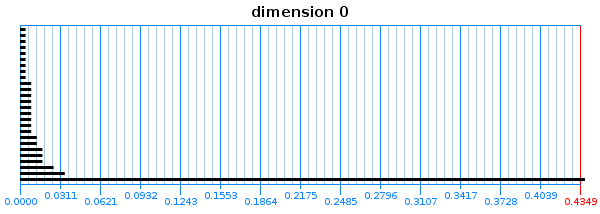

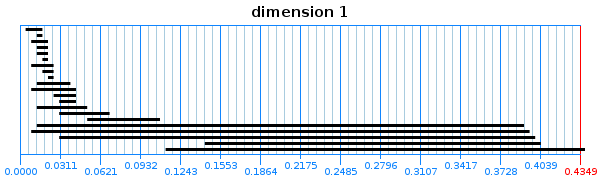

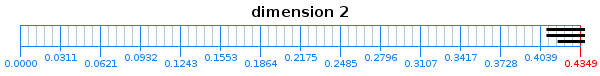

In [9]:
println(Seq(
  "Sampled image patches stream for",
  s"maxFiltrationValue = ${sampledFiltrationValue}",
  s"has ${sampledPatchesStreamSize} simplices").mkString("\n"))

drawBarcodes(sampledPatchesLandmarkImages)

## Isomap 

In [10]:
val isomap_ = time { isomap(subsampledPoints15, d = 3, k = 10) }
lazy val isomapReducedData = isomap_.getCoordinates

lazy val (isomapSampledPatchesStreamSize, isomapSampledFiltrationValue, (_, isomapSampledPatchesLandmarkImages))= lazyStreamIntervalsWithImages(isomapReducedData, 1)

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


Elapsed time: 1.173s


isomap_: IsoMap = smile.manifold.IsoMap@7ad00120
isomapReducedData: Array[Array[Double]] = <lazy>

Image patches reduced by Isomap stream for
maxFiltrationValue = 1.7746461111788854
has 2083 simplices

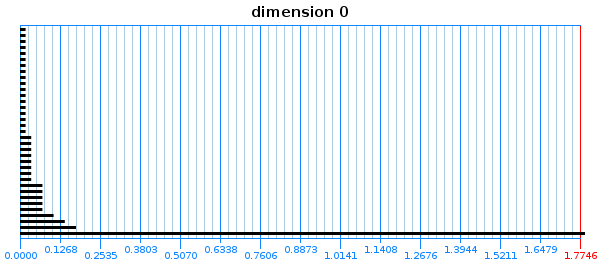

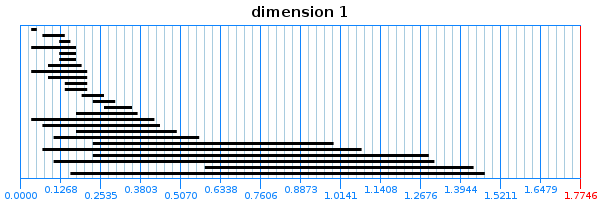

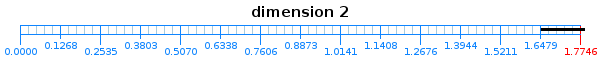

In [12]:
println(Seq(
  "Image patches reduced by Isomap stream for",
  s"maxFiltrationValue = ${isomapSampledFiltrationValue}",
  s"has ${isomapSampledPatchesStreamSize} simplices").mkString("\n"))

drawBarcodes(isomapSampledPatchesLandmarkImages)

## LLE ($d$ = 3)

In [13]:
val lle_ = time { lle(subsampledPoints15, d = 3, k = 10) }
lazy val lleReducedData = lle_.getCoordinates

lazy val (lleSampledPatchesStreamSize, lleSampledFiltrationValue, (_, lleSampledPatchesLandmarkImages))= lazyStreamIntervalsWithImages(lleReducedData, 3)

Elapsed time: 44.938s


lle_: LLE = smile.manifold.LLE@69568b37
lleReducedData: Array[Array[Double]] = <lazy>

Image patches reduced by LLE for
maxFiltrationValue = 0.107101224709659
has 243684 simplices

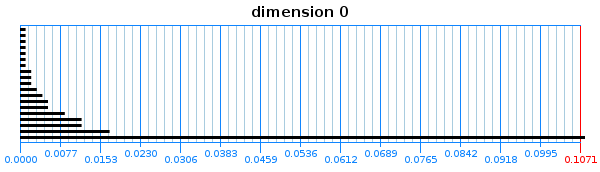

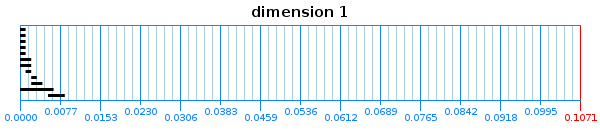

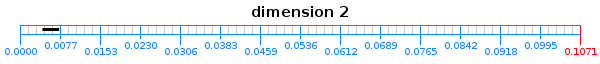

In [15]:
println(Seq(
  "Image patches reduced by LLE for",
  s"maxFiltrationValue = ${lleSampledFiltrationValue}",
  s"has ${lleSampledPatchesStreamSize} simplices").mkString("\n"))

drawBarcodes(lleSampledPatchesLandmarkImages)

## LLE ($d$ = 4)

In [16]:
val lle4_ = time { lle(subsampledPoints15, d = 4, k = 10) }
lazy val lle4ReducedData = lle_.getCoordinates

lazy val (lle4SampledPatchesStreamSize, lle4SampledFiltrationValue, (_, lle4SampledPatchesLandmarkImages))= lazyStreamIntervalsWithImages(lle4ReducedData, 2)

Elapsed time: 46.743s


lle4_: LLE = smile.manifold.LLE@7338e668
lle4ReducedData: Array[Array[Double]] = <lazy>

Image patches reduced by LLE stream for
maxFiltrationValue = 0.07101276904866091
has 167069 simplices


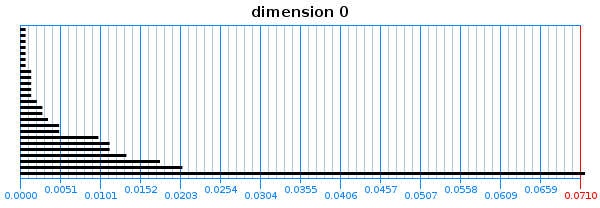

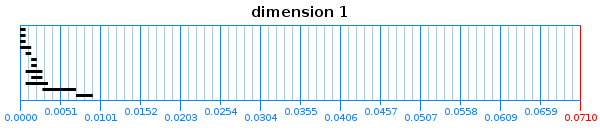

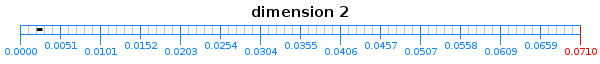

In [18]:
println(Seq(
  "Image patches reduced by LLE stream for",
  s"maxFiltrationValue = ${lle4SampledFiltrationValue}",
  s"has ${lle4SampledPatchesStreamSize} simplices").mkString("\n"))

drawBarcodes(lle4SampledPatchesLandmarkImages)

## KPCA

In [19]:
val kpca_ = kpca(subsampledPoints15, new kernel.PolynomialKernel(2, 2.0, 1.0), k = 3)
lazy val kpcaReducedData = kpca_.getCoordinates

lazy val (lle4SampledPatchesStreamSize, lle4SampledFiltrationValue, (_, lle4SampledPatchesLandmarkImages))= lazyStreamIntervalsWithImages(lle4ReducedData, 3)

kpca_: KPCA[Array[Double]] = smile.projection.KPCA@50544b41
kpcaReducedData: Array[Array[Double]] = <lazy>

Image patches (reduced by polynomial kernel KPCA) stream for
maxFiltrationValue = 0.10589552449355005
has 240316 simplices


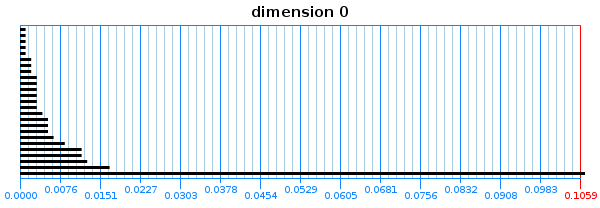

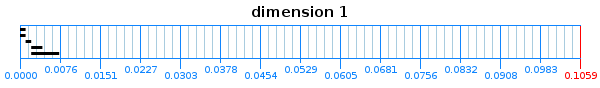

In [21]:
println(Seq(
  "Image patches (reduced by polynomial kernel KPCA) stream for",
  s"maxFiltrationValue = ${lle4SampledFiltrationValue}",
  s"has ${lle4SampledPatchesStreamSize} simplices").mkString("\n"))

drawBarcodes(lle4SampledPatchesLandmarkImages)